In [1]:
import pandas as pd

data_url = "./data/my_data.csv"
data = pd.read_csv(data_url)

data.head()

,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Jobs,Country,len_profile,len_description
0,Marketing,0,1,0,Other,Internship,NaN,Etc,Marketing,0,Intern,US,885,905
1,etc,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,Service,NZ,1286,2077
2,etc,0,1,0,NaN,NaN,NaN,Etc,NaN,0,Assistant,US,879,355
3,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,etc,US,614,2600
4,etc,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Manager,US,1628,1520


In [2]:
# split dataset to train/valid/test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val =  train_test_split(train, test_size=len(test), random_state=2)

train.shape, val.shape, test.shape

((10728, 14), (3576, 14), (3576, 14))

In [3]:
train.head().T

,16443,15778,6781,15799,16271
department,Engineering,etc,etc,Sales,Marketing
telecommuting,1,0,0,0,0
has_company_logo,1,1,0,1,1
has_questions,1,1,0,1,1
employment_type,Full-time,Full-time,Full-time,Full-time,Full-time
required_experience,Mid-Senior level,Mid-Senior level,Entry level,Associate,NaN
required_education,Bachelor's Degree,NaN,High School or equivalent,Unspecified,NaN
industry,Internet,Computer Software,Education Management,Pharmaceuticals,E-Learning
function,Engineering,Engineering,Education,Sales,NaN
fraudulent,0,0,0,0,0


In [4]:
train.dtypes

department             object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
Jobs                   object
Country                object
len_profile             int64
len_description         int64
dtype: object

In [6]:
target = "fraudulent"

train[target].value_counts(normalize=True)

0    0.951063
1    0.048937
Name: fraudulent, dtype: float64

In [7]:
train.T.duplicated()

department             False
telecommuting          False
has_company_logo       False
has_questions          False
employment_type        False
required_experience    False
required_education     False
industry               False
function               False
fraudulent             False
Jobs                   False
Country                False
len_profile            False
len_description        False
dtype: bool

In [8]:
# 혹시 너무 많은 범주를 가지는 카테고리 특성들이 있는지 카디널리티(cardinality)를 확인해 봅시다.

train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
employment_type,8628,5,Full-time,6922
required_experience,6494,7,Mid-Senior level,2280
department,10728,11,etc,8694
Country,10728,12,US,6419
required_education,5894,13,Bachelor's Degree,3098
Jobs,10728,17,etc,4386
function,6856,37,Information Technology,1069
industry,10728,129,Etc,2946


In [9]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [11]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy')
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  1.0
검증 정확도:  0.9731543624161074


In [12]:
# named_steps 속성을 사용해서 파이프라인의 각 스텝에 접근이 가능합니다.
pipe.named_steps

{'onehotencoder': OneHotEncoder(cols=['department', 'employment_type', 'required_experience',
                     'required_education', 'industry', 'function', 'Jobs',
                     'Country'],
               use_cat_names=True),
 'simpleimputer': SimpleImputer(),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', random_state=1)}

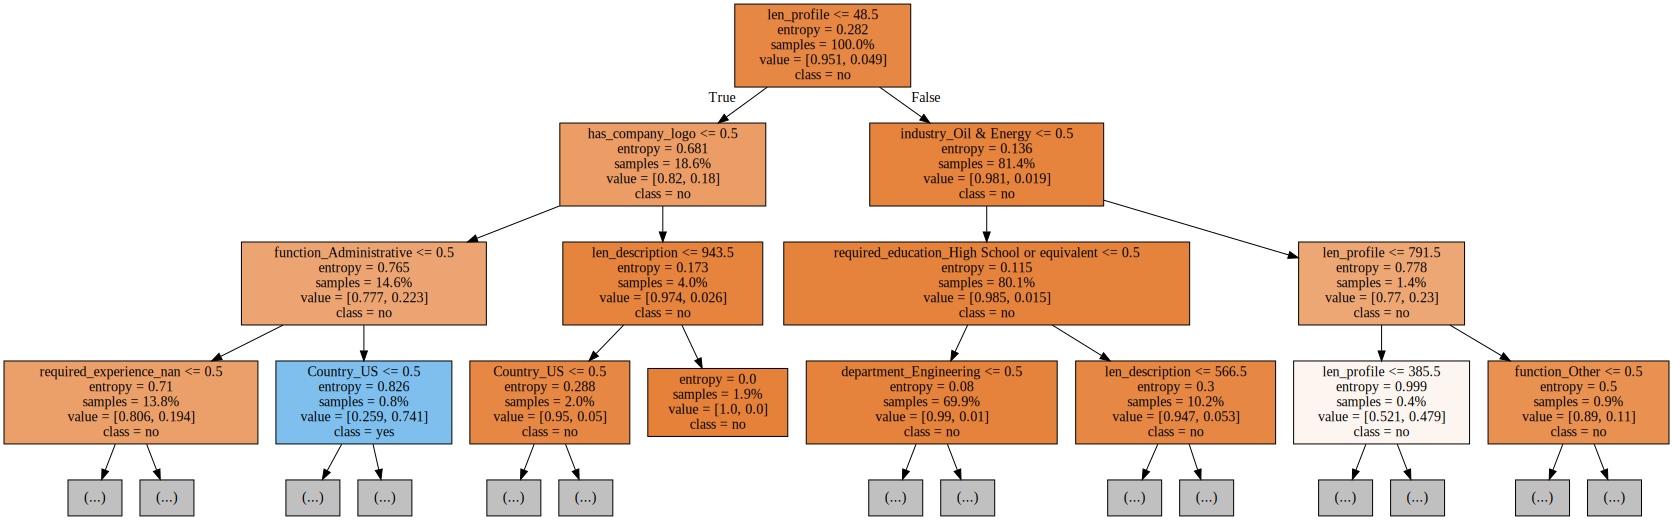

In [13]:
import graphviz
from sklearn.tree import export_graphviz

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

In [14]:
# tune 'min_samples_leaf'
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=10, random_state=2)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.9746457867263236
검증 정확도 0.9731543624161074


In [15]:
# tune 'max_depth'
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=6, random_state=2)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.9679343773303505
검증 정확도 0.9644854586129754


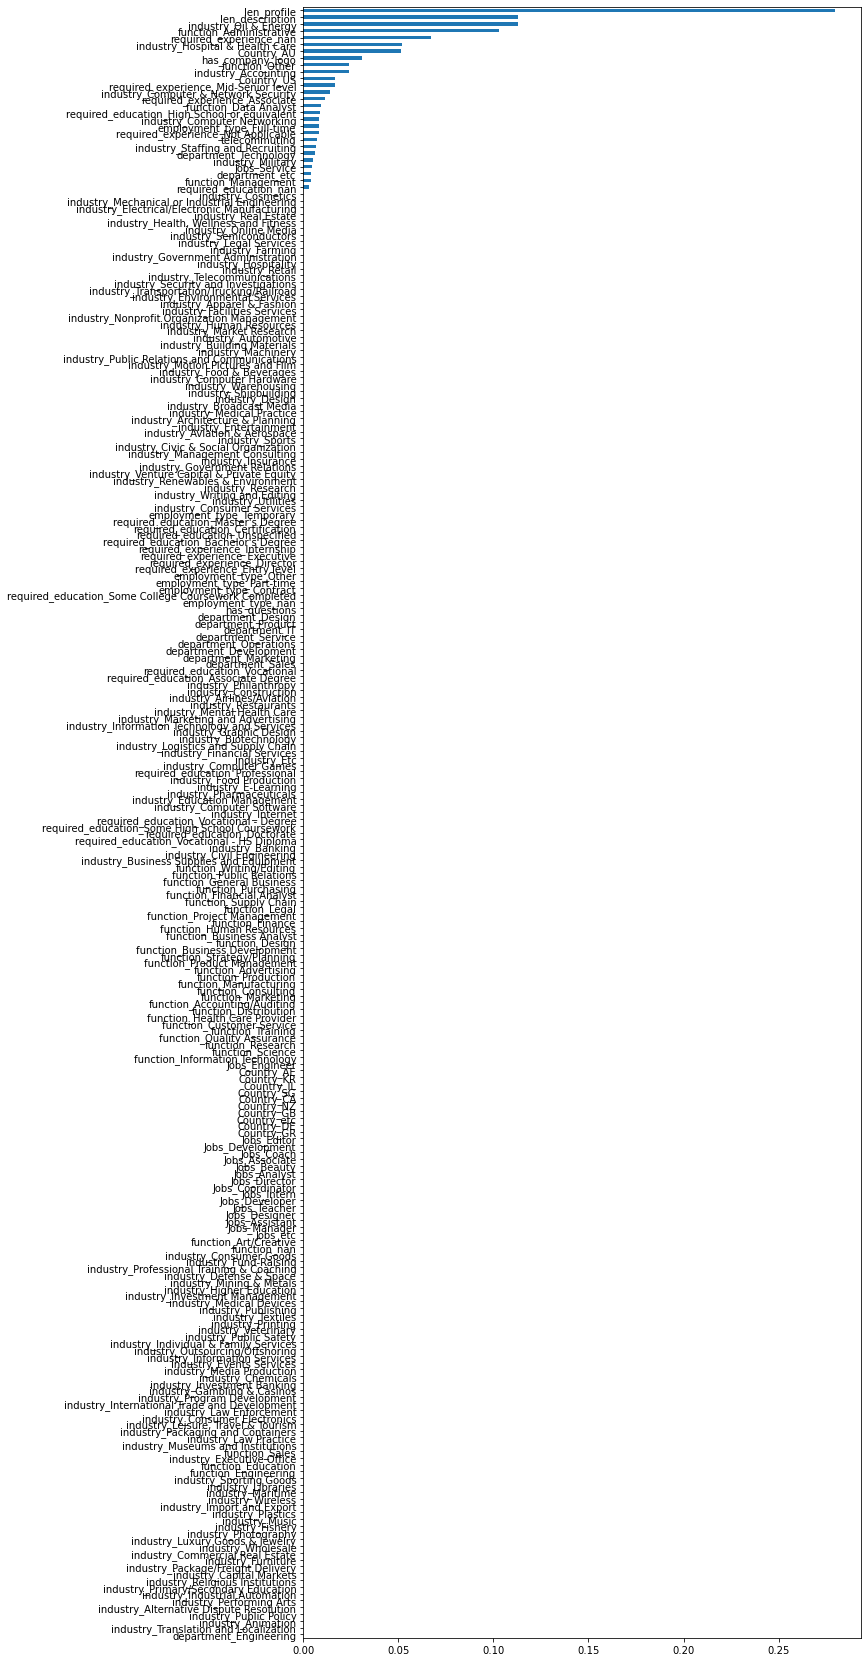

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

model_dt = pipe.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();